# Traditional Sentiment Analysis

Sentiment classification system using traditional machine learning

An improved Recurrent Neural Network version can be found in the [data-science-keras](https://github.com/angelmtenor/data-science-keras/blob/master/sentiment_IMDB.ipynb) repository.

Dataset: [Stanford's Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/). Movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either 'positive', if the reviewer enjoyed the film, or 'negative' otherwise.

Structure of the data: 
- train/
     - pos/
     - neg/
- test/
     - pos/
     - neg/


Based on [Sentiment Analysis exercise](https://github.com/udacity/AIND-NLP/blob/master/sentiment_analysis.ipynb) of the [Udacity's Artificial Intelligence Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [2]:
import os
import glob
import zipfile


def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory """

    if not os.path.isdir(data_dir):
        print("Extracting data ...")
        with zipfile.ZipFile("data/imdb-reviews.zip","r") as zip_ref:
            zip_ref.extractall('data')
    
    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [3]:
print(data['train']['pos'][2])

As far as horror flicks go, this one is pretty darn good. While it may not be a classic tale of horror and suspense, it does provide many quality chuckles that make this movie a must see if you're into the horror/comedy genre.


### Wordcloud visualization

Positive reviews:


(-0.5, 799.5, 399.5, -0.5)

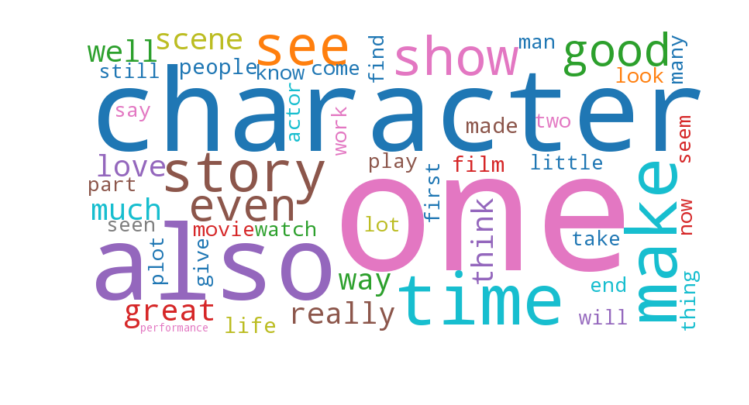

In [4]:
from wordcloud import WordCloud, STOPWORDS

# Combine all reviews for the desired sentiment
pos_text = " ".join([review for review in data['train']['pos']])

# update stopwords to include common words like film and movie
stopwords = STOPWORDS.update(['br','film','movie'])

# Generate and plot wordcloud
wc = WordCloud(background_color='white', max_words=50, width=400, height=200, scale=2,
        colormap="tab10")       
plt.figure(figsize=(4, 3), dpi=200)
print("Positive reviews:")
plt.imshow(wc.generate(pos_text), interpolation='bilinear')
plt.axis('off')

## Split into training and test sets


In [5]:
from sklearn.utils import shuffle

# Combine positive and negative reviews and labels
data_train = data['train']['pos'] + data['train']['neg']
data_test = data['test']['pos'] + data['test']['neg']    
labels_train = labels['train']['pos'] + labels['train']['neg']
labels_test = labels['test']['pos'] + labels['test']['neg']    

# Shuffle reviews and corresponding labels within training and test sets
data_train, labels_train = shuffle(data_train, labels_train, random_state=9)
data_test, labels_test = shuffle(data_test, labels_test, random_state=9)

print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Preprocess the data

In [6]:
from bs4 import BeautifulSoup 
import re
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer

def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    review = BeautifulSoup(review, "html5lib").get_text()  # remove HTML tags
    review = re.sub(r"[^a-zA-Z0-9]", " ", review)  # remove non-letters
    review = review.lower()  # convert to lowercase
    words = review.split()  # tokenize
    words = [w for w in words if w not in stopwords.words("english")]  # remove stopwords    
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]  # stem

    
    # Return final list of words
    return words

review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

[nltk_data] Downloading package stopwords to /home/angel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['test', 'test', 'would', 'make', 'great', 'movi', 'review']

In [7]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
First of all, I liked very much the central idea of locating the '' intruders'', Others in the fragile Self, on various levels - mainly subconscious but sometimes more allegorical. In fact the intruders are omnipresent throughout the film : in the Swiss-French border where the pretagonist leads secluded life; in the his recurring daydream and nightmare; inside his ailing body after heart transplantation.... In the last half of the film, he becomes intruder himself, returning in ancient french colony in the hope of atoning for the past. <br /><br />The overall tone is bitter rather than pathetic, full of regrets and guilts, sense of failure being more or less dominant. This is a quite grim picture of an old age, ostensibly self-dependent but hopelessly void and lonely inside. The directer composes the images more to convey passing sensations of anxiety and desire than any explicit meanings. Some of them ar

## Extract Bag-of-Words features

In [8]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:

        vectorizer = CountVectorizer(decode_error='ignore', max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray()

        features_test = vectorizer.fit_transform(words_test).toarray()
               
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary
    
words_train, words_test = data_train, data_test   

# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['fu', 'target', 'comments', 'wears', 'ways', 'argument', 'drink', 'hype']

--- Preprocessed words ---
The film is about Sir Christopher Strong (MP--member of Parliament--played by Colin Clive) and his affair with the Amelia Earhart-like character played by Katherine Hepburn. Up until they met, he had been a very devoted husband but when he met the odd but fascinating Hepburn, he "couldn't help himself" and they fell in love. You can tell, because they stare off into space a lot and talk ENDLESSLY about how painful their unrequited love is. Frankly, this is a terribly dated and practically impossible film to watch. Part of the problem is that in the Pre-Code days, films glamorizing adultery were very common. Plus, even if you accept this morally suspect subject, the utter sappiness of the dialog make it sound like a 19th century romance novel...and a really bad one at that. Sticky and with difficult to

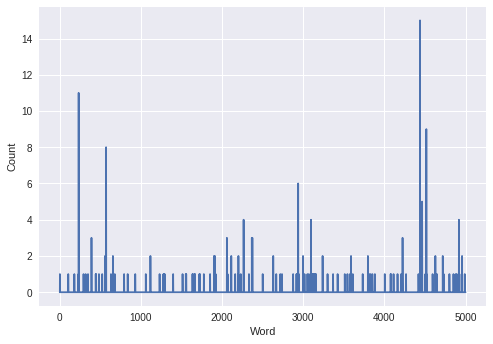

In [9]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Zipf's law

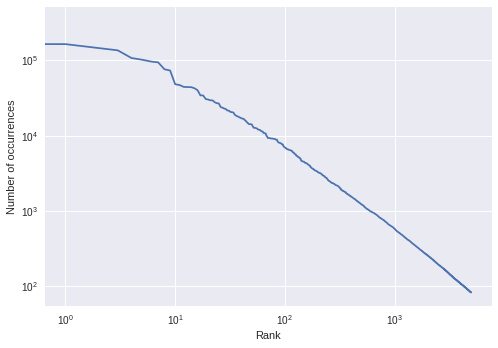

In [10]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

### Normalize feature vectors

In [11]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train.astype('float64'))
features_test = pr.normalize(features_test.astype('float64'))

## Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [12]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf1 = GaussianNB().fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.83652, test = 0.53808


### Gradient-Boosted Decision Tree classifier

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

n_estimators = 40

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1, max_depth=1, random_state=9)

    # Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)
      
    # Print final training & test accuracy
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    acc_train = accuracy_score(pred_train, y_train)
    acc_test = accuracy_score(pred_test, y_test)
    
    print("training accuracy: {:.6f}".format(acc_train))
    print("test accuracy: \t {:.6f}".format(acc_test))
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

training accuracy: 0.801520
test accuracy: 	 0.592240


### Classify a new review

In [14]:
# Write a sample review and set its true sentiment
my_review = "The writer and director did well on his first movie, but this one is an absolute nonsense. \
I like complicated, non-linear and abstract movies, the more I learn from the them the better. \
The photography is good, although nothing can be learn from this lame script"
true_sentiment = 'neg' 

# Apply the same preprocessing and vectorizing
my_words = review_to_words(my_review)
my_vectorizer = CountVectorizer(decode_error='ignore', vocabulary=vocabulary)
my_words = my_vectorizer.fit_transform(my_words).toarray()

# call the classifier
print(clf2.predict(my_words[0].reshape(1, -1)))

['pos']


The accuracy of the test set is low, and most of the manual reviews predict a positive sentiment. 

An improved Recurrent Neural Network version can be found [here](https://github.com/angelmtenor/data-science-keras/blob/master/sentiment_IMDB.ipynb) .